In [1]:
# Import libraries for data handling, visualization, modeling, and live data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf  # For fetching live stock data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.express as px  # For interactive plots
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

print("Libraries imported successfully!")

Libraries imported successfully!


In [24]:
print(f"Trading Days: {len(data)}")
print(f"Avg Close: ${data['Close'].mean():.2f}")
print(f"Avg Volume: {data['Volume'].mean():.0f}")

Trading Days: 5997
Avg Close: $7.39
Avg Volume: 8172299


In [2]:
data = pd.read_csv('Coca-Cola_stock_history.csv')
# Ensure Date is datetime (fallback in case earlier steps failed)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Add date-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Day_of_Week'] = data['Date'].dt.dayofweek

# Add previous day's Close price as a feature
data['Prev_Close'] = data['Close'].shift(1)

# Moving average crossover strategy (Short MA = 10 days, Long MA = 50 days)
data['Short_MA'] = data['Close'].rolling(window=10).mean()
data['Long_MA'] = data['Close'].rolling(window=50).mean()
data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, -1)  # 1 = Buy, -1 = Sell

# Drop rows with NaN values from new features
data.dropna(inplace=True)

print("First 5 rows with new features:")
print(data.head())

First 5 rows with new features:
         Date      Open      High       Low     Close   Volume  Dividends  \
49 1962-03-13  0.046416  0.046789  0.046416  0.046789  1344000   0.001563   
50 1962-03-14  0.046789  0.046976  0.046603  0.046852  1689600   0.000000   
51 1962-03-15  0.046852  0.046976  0.046603  0.046603   883200   0.000000   
52 1962-03-16  0.046603  0.046789  0.046603  0.046603   768000   0.000000   
53 1962-03-19  0.046603  0.047101  0.046603  0.046852   921600   0.000000   

    Stock Splits    Year  Month   Day  Day_of_Week  Prev_Close  Short_MA  \
49             0  1962.0    3.0  13.0          1.0    0.046054  0.045633   
50             0  1962.0    3.0  14.0          2.0    0.046789  0.045774   
51             0  1962.0    3.0  15.0          3.0    0.046852  0.045916   
52             0  1962.0    3.0  16.0          4.0    0.046603  0.046008   
53             0  1962.0    3.0  19.0          0.0    0.046603  0.046187   

     Long_MA  Signal  
49  0.046525      -1  
50

In [3]:
# Check for missing values
print("Null values in the dataset:")
print(data.isnull().sum())

# Ensure numeric columns are properly typed
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, NaN if invalid

# Fill missing values with the previous value (forward fill)
data.fillna(method='ffill', inplace=True)

# Debug: Check Close column stats before outlier removal
print("\nClose column stats:")
print(data['Close'].describe())
print(f"Shape before preprocessing: {data.shape}")

# Calculate IQR bounds for outlier removal
Q1, Q3 = data['Close'].quantile(0.25), data['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"IQR Bounds - Lower: {lower_bound}, Upper: {upper_bound}")

# Apply outlier removal (but keep it optional for now)
data_no_outliers = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]
print(f"Shape after outlier removal: {data_no_outliers.shape}")

# If too many rows are lost, skip outlier removal for now
if data_no_outliers.shape[0] < data.shape[0] * 0.5:  # If >50% rows removed
    print("Warning: Outlier removal removed too many rows. Skipping for now.")
    data_cleaned = data.copy()  # Keep original data
else:
    data_cleaned = data_no_outliers.copy()

# Check if data is empty
if data_cleaned.empty:
    raise ValueError("Data is still empty after preprocessing! Check Close column or CSV data.")
else:
    data = data_cleaned  # Assign back to data for next steps
    print(f"Final shape after preprocessing: {data.shape}")

Null values in the dataset:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Year            0
Month           0
Day             0
Day_of_Week     0
Prev_Close      0
Short_MA        0
Long_MA         0
Signal          0
dtype: int64

Close column stats:
count    6422.000000
mean       10.072475
std        13.876871
min         0.039314
25%         0.220790
50%         2.006821
75%        15.085040
max        61.476925
Name: Close, dtype: float64
Shape before preprocessing: (6422, 16)
IQR Bounds - Lower: -22.075584486875, Upper: 37.381414836125
Shape after outlier removal: (5997, 16)
Final shape after preprocessing: (5997, 16)


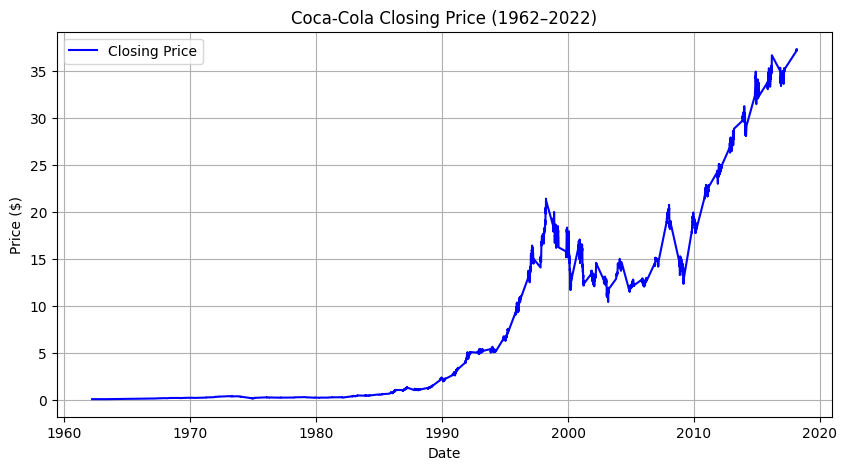

In [11]:
# Plot the Close price over time
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.title('Coca-Cola Closing Price (1962–2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.savefig('closing_price.png')
plt.show()

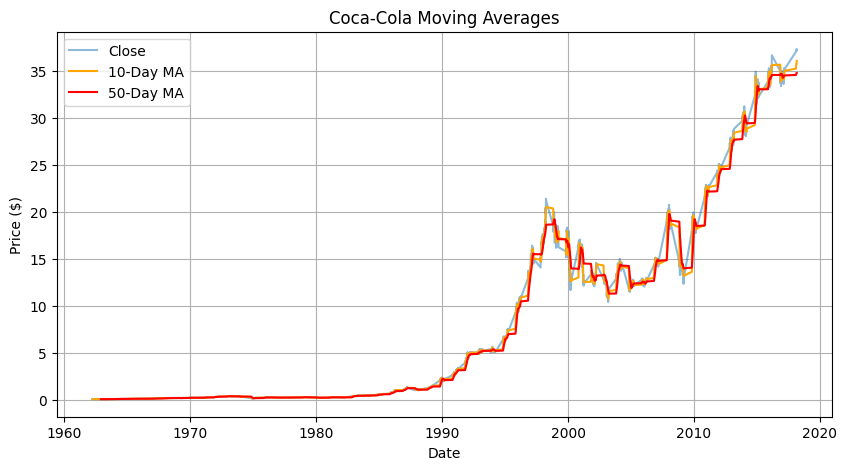

In [13]:
# Calculate 10-day and 50-day moving averages
data['10_MA'] = data['Close'].rolling(window=10).mean()
data['50_MA'] = data['Close'].rolling(window=50).mean()

plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], label='Close', alpha=0.5)
plt.plot(data['Date'], data['10_MA'], label='10-Day MA', color='orange')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')
plt.title('Coca-Cola Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.savefig('moving_averages.png')
plt.show()

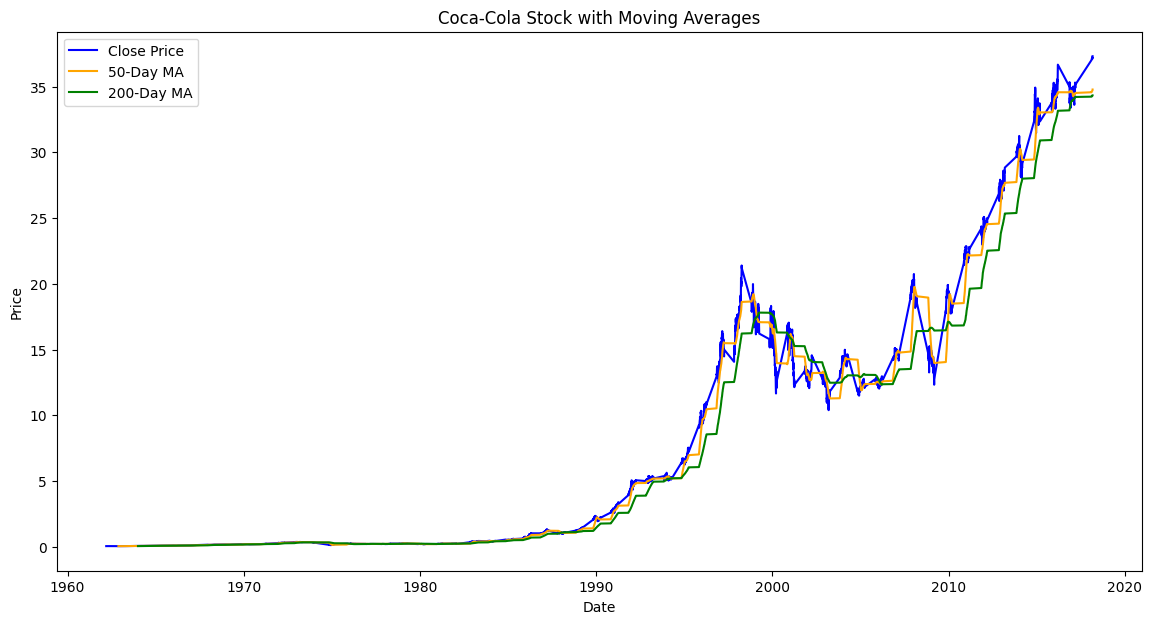

In [6]:
# Calculate 50-day and 200-day moving averages
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Plot Close price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['MA50'], label='50-Day MA', color='orange')
plt.plot(data['Date'], data['MA200'], label='200-Day MA', color='green')
plt.title('Coca-Cola Stock with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('price_trends.png')
plt.show()

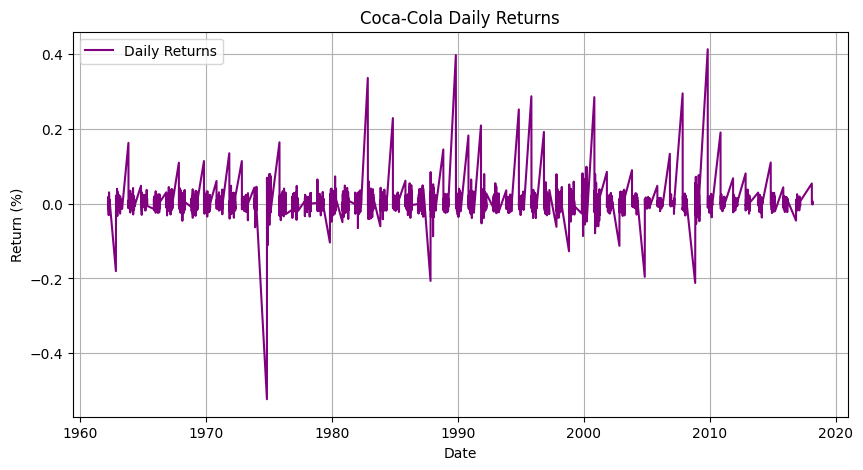

In [14]:
#daily returns
data['Returns'] = data['Close'].pct_change()

plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Returns'], label='Daily Returns', color='purple')
plt.title('Coca-Cola Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid()
plt.savefig('daily_returns.png')
plt.show()

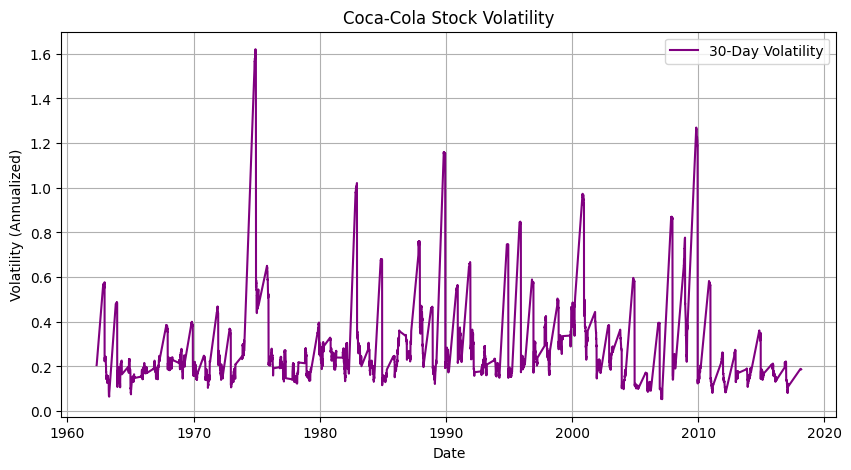

In [7]:
#volatility
data['Returns'] = data['Close'].pct_change()
data['Volatility'] = data['Returns'].rolling(window=30).std() * (252 ** 0.5)

plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Volatility'], label='30-Day Volatility', color='purple')
plt.title('Coca-Cola Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Annualized)')
plt.legend()
plt.grid()
plt.savefig('volatility.png')
plt.show()

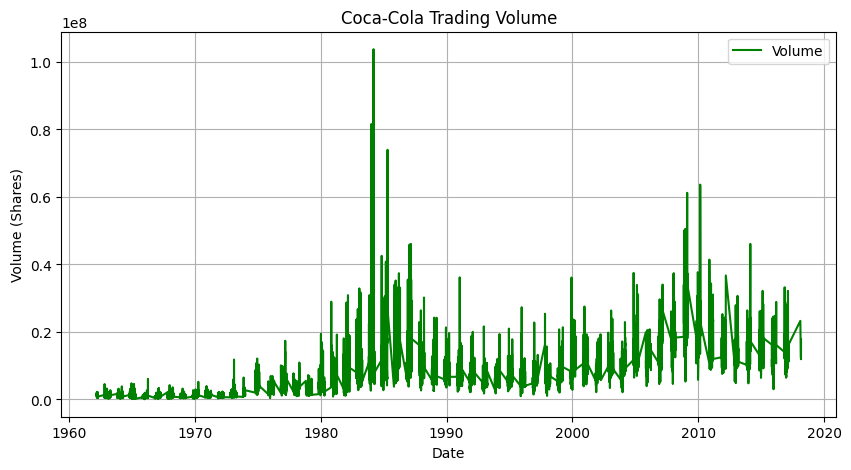

In [10]:
#Volume check
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Volume'], label='Volume', color='green')
plt.title('Coca-Cola Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume (Shares)')
plt.legend()
plt.grid()
plt.savefig('volume.png')
plt.show()

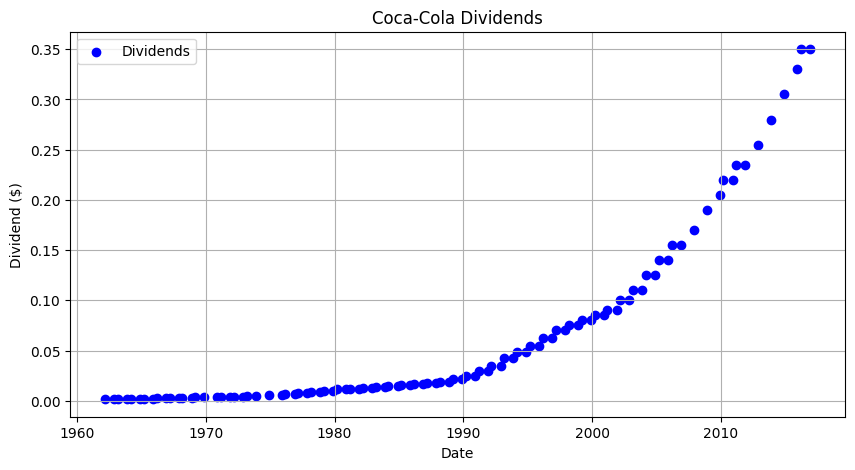

In [15]:
#Dividend Impact
dividends = data[data['Dividends'] > 0]

plt.figure(figsize=(10, 5))
plt.scatter(dividends['Date'], dividends['Dividends'], label='Dividends', color='blue')
plt.title('Coca-Cola Dividends')
plt.xlabel('Date')
plt.ylabel('Dividend ($)')
plt.legend()
plt.grid()
plt.savefig('dividends.png')
plt.show()

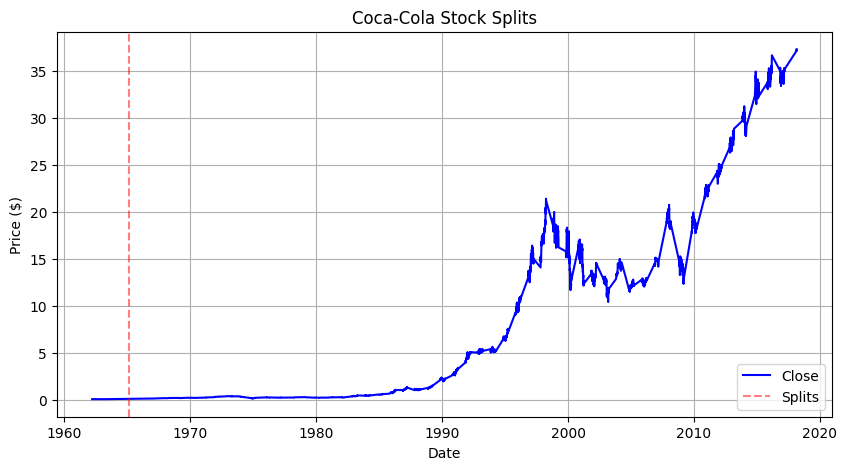

In [17]:
#Stock Splits
splits = data[data['Stock Splits'] > 0]

plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
for split_date in splits['Date']:
    plt.axvline(x=split_date, color='red', linestyle='--', alpha=0.5)
plt.title('Coca-Cola Stock Splits')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(['Close', 'Splits'])
plt.grid()
plt.savefig('stock_splits.png')
plt.show()

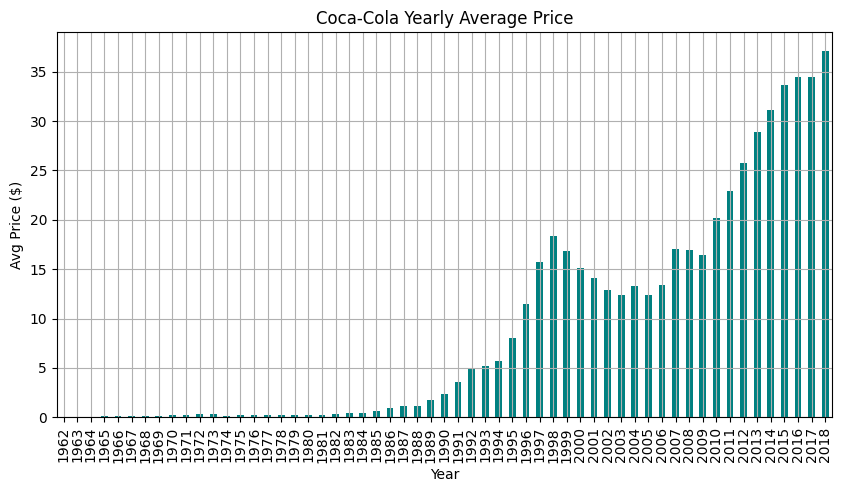

In [18]:
#Yearly Prerformance
data['Year'] = data['Date'].dt.year

yearly_avg = data.groupby('Year')['Close'].mean()

plt.figure(figsize=(10, 5))
yearly_avg.plot(kind='bar', color='teal')
plt.title('Coca-Cola Yearly Average Price')
plt.xlabel('Year')
plt.ylabel('Avg Price ($)')
plt.grid()
plt.savefig('yearly_price.png')
plt.show()

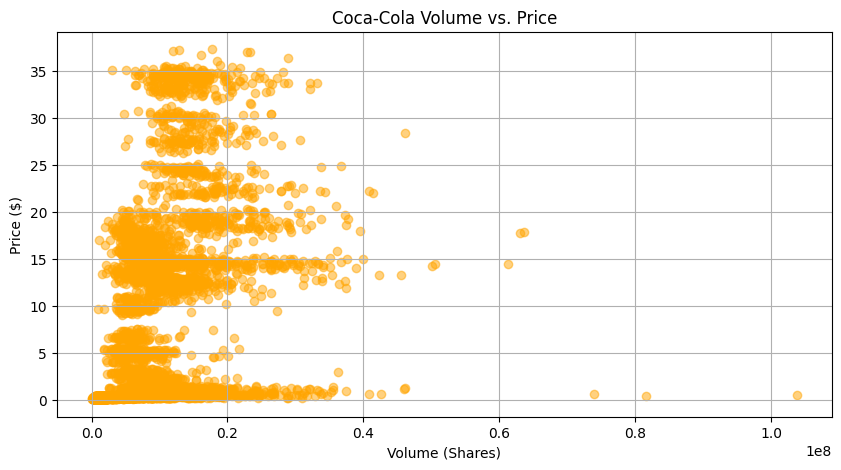

In [20]:
#Volume Vs Price
plt.figure(figsize=(10, 5))
plt.scatter(data['Volume'], data['Close'], alpha=0.5, color='orange')
plt.title('Coca-Cola Volume vs. Price')
plt.xlabel('Volume (Shares)')
plt.ylabel('Price ($)')
plt.grid()
plt.savefig('volume_vs_price.png')
plt.show()

In [ ]:
# Correlation heatmap of numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
# Add date-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Day_of_Week'] = data['Date'].dt.dayofweek

# Add previous day's Close price as a feature
data['Prev_Close'] = data['Close'].shift(1)

# Moving average crossover strategy (Short MA = 10 days, Long MA = 50 days)
data['Short_MA'] = data['Close'].rolling(window=10).mean()
data['Long_MA'] = data['Close'].rolling(window=50).mean()
data['Signal'] = np.where(data['Short_MA'] > data['Long_MA'], 1, -1)  # 1 = Buy, -1 = Sell

# Drop rows with NaN values from new features
data.dropna(inplace=True)

print("First 5 rows with new features:")
print(data.head())

In [ ]:
# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']
X = data[features]
y = data['Close']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

In [ ]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate the model
print("Linear Regression Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test, lr_pred):.2f}")
print(f"R-Squared: {r2_score(y_test, lr_pred):.2f}")

In [ ]:
# Prepare data for LSTM (time-series model)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[['Close']])  # Scale Close price to 0-1

# Create sequences (use 10 days to predict the next day)
lookback = 10
X_lstm, y_lstm = [], []
for i in range(lookback, len(X_scaled)):
    X_lstm.append(X_scaled[i-lookback:i, 0])  # Past 10 days
    y_lstm.append(X_scaled[i, 0])             # Next day
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))  # Shape for LSTM

# Split for LSTM
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

print(f"LSTM Training set size: {X_train_lstm.shape}")
print(f"LSTM Testing set size: {X_test_lstm.shape}")

In [ ]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

In [ ]:
# Make predictions with LSTM
lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)  # Convert back to original scale
y_test_lstm_inv = scaler.inverse_transform([y_test_lstm])

# Evaluate LSTM
print("\nLSTM Results:")
print(f"Mean Squared Error: {mean_squared_error(y_test_lstm_inv.T, lstm_pred):.2f}")

In [ ]:
# Linear Regression: Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test, lr_pred, color='blue', label='Predicted vs Actual (Linear)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# LSTM: Actual vs Predicted (last 100 points for clarity)
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm_inv.T[-100:], label='Actual Close Price', color='blue')
plt.plot(lstm_pred[-100:], label='Predicted Close Price (LSTM)', color='red')
plt.title('LSTM: Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Plot moving average crossover strategy
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['Short_MA'], label='10-Day MA', color='orange')
plt.plot(data['Date'], data['Long_MA'], label='50-Day MA', color='green')
plt.scatter(data['Date'], data['Close'] * data['Signal'], c=data['Signal'], cmap='cool', label='Buy/Sell Signal')
plt.title('Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Flatten Actual_Close if it's 2D
actual_close = y_test_lstm_inv.flatten()

# Save predictions to CSV
predictions_data = pd.DataFrame({
    'Date': data['Date'].iloc[-len(lstm_pred):].values,
    'Actual_Close': actual_close,
    'Predicted_Close_LSTM': lstm_pred.flatten()
})
predictions_data.to_csv('Coca-Cola-Prediction.csv', index=False)

# Save the LSTM model
lstm_model.save('coca_cola_lstm_model.h5')
lstm_model.save('coca_cola_lstm_model.keras')


print("Predictions saved to 'Coca-Cola-Prediction.csv' and model saved as 'coca_cola_lstm_model.h5'")
